In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Parameter setup
(same with true_Bellman_iteration.ipynb)

In [2]:
#### basic dimensions and state space grid:

N_P = 2 # price grid dimension - 1 (because we start from 0)

N_Y = 1 # (inventory grid dimension - 1)/2 (because we allow both - and + and 0)

dim_X = 2*N_P-1

dim_Y = 2*N_Y+1

prices = list(range(N_P+1)) # all integer list [0,1,2,...,N_P]
prices = np.array(prices)

dim_action_a = N_P+2
dim_action_b = N_P+2
# the additional state (the last 1) for quoted price is for doing nothing

#### set (tick size, time grid, transition kernel)

tick = 1/3 # the quoted prices are in the set: (0*tick, 1*tick, 2*tick, ..., N_P*tick)

Delta = 0.1 # the actions are done in the grid: 0*Delta, 1*Delta, 2*Delta, ......

k1 = 2 # 2/(tick*M), where M is an integer specifying the optimal spread, as multiple of (tick/2)

p0 = 0.4

A = np.exp(1)*(1/Delta)*p0

def lambda_e(D): # if the distance between the quoted price and the mid-price is D>0, then the probability that this order is executed is lambda_e(D)*Delta.
    return np.exp(-k1*D)*A

#### discount factor for the infinite horizon value function

GAMMA = 0.95
GAMMA_Delta = np.exp(-GAMMA*Delta)

print(GAMMA_Delta)

#### transition prob matrix of state variable X_i , where X_i is the mid-price

Q_X_i_i1 = np.zeros((dim_X-1,dim_X))
Q_X_i1_i = np.zeros((dim_X-1,dim_X))

lambda_i_i1 = (1/Delta)*np.array([0.5,1/3]) #3.5*np.ones(dim_X-1)
lambda_i1_i = (1/Delta)*np.array([1/3,0.5]) #3.5*np.ones(dim_X-1)

for i in range(dim_X-1):
  Q_X_i1_i[i,i] = lambda_i1_i[i]
  Q_X_i1_i[i,i+1] = -lambda_i1_i[i]
  Q_X_i_i1[i,i] = -lambda_i_i1[i]
  Q_X_i_i1[i,i+1] = lambda_i_i1[i]

Q_X = np.zeros((dim_X,dim_X))
Q_X[0:(dim_X-1), 0:dim_X] = Q_X[0:(dim_X-1), 0:dim_X] + Q_X_i_i1
Q_X[1:dim_X, 0:dim_X] = Q_X[1:dim_X, 0:dim_X] + Q_X_i1_i

P_X = np.identity(dim_X) + Delta*Q_X # X_i is a finite-state Markov jump process, and the transition probability matrix of X_i is P_X.
print(P_X)

0.9093729344682314
[[0.5        0.5        0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         0.5        0.5       ]]


## Parameters of the Q-learning algorithms

3.5919237134836712e-34
0.0015474250491067279


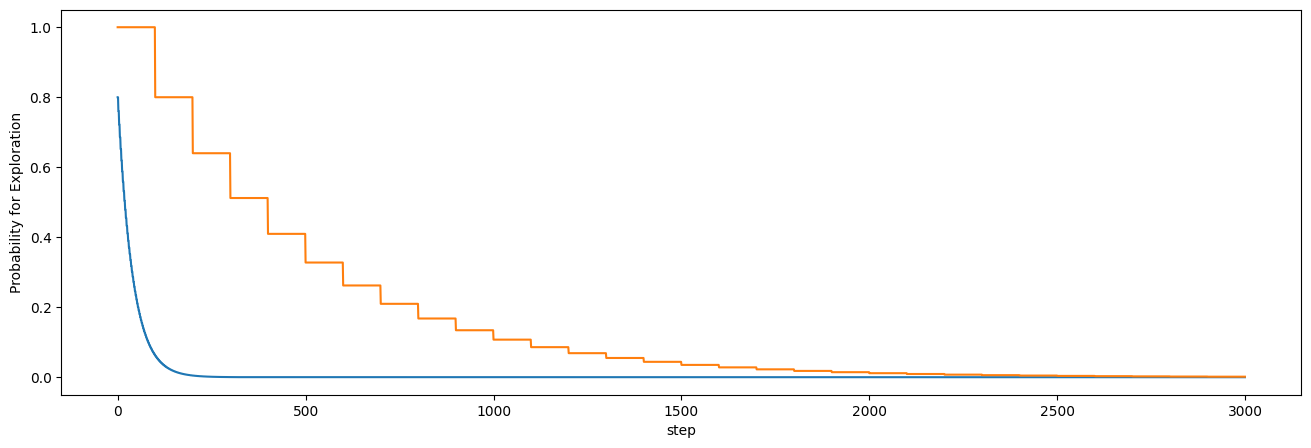

In [3]:
%matplotlib inline

Q_table = np.zeros( (dim_X, dim_Y, dim_action_a, dim_action_b) )

N_RL_iter = 10000 # total steps of Q-learning iteration

Q_table_track = np.zeros( (dim_X, dim_Y, dim_action_a, dim_action_b, N_RL_iter) )

N_learning_steps = 3000 # total steps of Q-learning iteration for each (state,action) pair

# count the numbers of visiting
state_counter_matrix = np.zeros( (dim_X, dim_Y) )
state_action_counter_matrix = np.zeros( (dim_X, dim_Y, dim_action_a, dim_action_b) )

###### learning rate
eps = 0.8
eps0 = 0.95
epoch = 2
learning_rate = [eps*((eps0)**(i//epoch)) for i in range(N_learning_steps)] #step_size = learning_rate

learning_rate_matrix = np.zeros( (dim_X, dim_Y, dim_action_a, dim_action_b, N_learning_steps) )
######## should also let the learning rate depends on action, because Q function is a function of (s,a)

for idx_x in range(dim_X):
  for idx_y in range(dim_Y):
    for p_a in range(dim_action_a):
      for p_b in range(dim_action_b):
        learning_rate_matrix[ idx_x, idx_y, p_a, p_b, : ] = np.array(learning_rate)
plt.figure(1, figsize=(16, 5))
plt.plot(learning_rate)
plt.xlabel('step')
plt.ylabel('Learning Rate')
print(learning_rate[-5])

####### exploration probability
eps = 1.0
eps0 = 0.8
epoch = 100
EPSILON_list = [eps*((eps0)**(i//epoch)) for i in range(N_learning_steps)] # Probability for exploration
#EPSILON_list = [ 0 for i in range(N_learning_steps)] # Probability for exploration
explore_prob_matrix = np.zeros( (dim_X, dim_Y, N_learning_steps) )
######## should also let the exploration probability depend on state s
for idx_x in range(dim_X):
  for idx_y in range(dim_Y):
    explore_prob_matrix[ idx_x, idx_y, : ] = np.array(EPSILON_list)
plt.figure(1, figsize=(16, 5))
plt.plot(EPSILON_list)
plt.xlabel('step')
plt.ylabel('Probability for Exploration')
print(EPSILON_list[-5])


# Tabular Q-learning with epsilon-greedy

In [4]:
np.random.seed(999)

In [5]:
# the data of state variables at time point i=0,1,...,N_RL_iter
X_data = np.zeros(N_RL_iter+1) # all are integers, i.e., 0,1,2,...,dim_X-1
Y_data = np.zeros(N_RL_iter+1) # all are integers, i.e., 0,1,2,...,dim_Y-1

Reward_i_data = np.zeros(N_RL_iter) # the reward from i to i+1 for i=0,1,...,N_RL_iter-1
dna_data = np.zeros(N_RL_iter) # the executed ask order size from i to i+1 for i=0,1,...,N_RL_iter-1
dnb_data = np.zeros(N_RL_iter) # the executed buy order size from i to i+1 for i=0,1,...,N_RL_iter-1

# state initialization

X_data[0] = dim_X//2
Y_data[0] = dim_Y//2

for i in range(N_RL_iter):
  # the transition from i to i+1
  Q_table_track[:,:,:,:,i] = Q_table[:,:,:,:]
  # main part of the Q-learning algorithm

  # Part 1: choose the action to do given the state at i-th time point
  p_a = 0 # quoted ask price
  p_b = 0 # quoted bid price
  #########
  # Make a list of the actions available from the current state
  idx_x = int(X_data[i]) # all are integers, i.e., 0,1,2,...,dim_X-1
  idx_y = int(Y_data[i]) # all are integers, i.e., 0,1,2,...,dim_Y-1


  count_xy = int(state_counter_matrix[idx_x,idx_y])
  state_counter_matrix[idx_x,idx_y] = count_xy+1

  EPSILON = explore_prob_matrix[ idx_x, idx_y, count_xy ]  #exploration probability for this state

  x = idx_x + 1 # midprice=x*tick_size/2 and x is in (1,2,...,dim_X)
  y = idx_y - N_Y # y = the true signed integer value of inventory

  if y == -N_Y: # then sell order is not allowed
    action_a_list = [dim_action_a-1] # do nothing for ask order
    action_b_list = prices[prices<x/2] # the action is exactly equal to the index
    # x/2 is because the middle price is on grid: 0, 1/2, 1, 3/2, 2, ...,
    # but the quoted price is on grid: 0,1,2,...
    p_a = dim_action_a-1

    if np.random.binomial(1, EPSILON) == 1:
      p_b = np.random.choice(action_b_list)
    else:
      Q_values_xy = Q_table[idx_x, idx_y, :, :][np.ix_( list(action_a_list), list(action_b_list) )]
      idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
      p_b = action_b_list[ idx_max_b[0] ]
      # Wrong(do not do this!!! the index list is different!!): indeed, we can directly use idx_max_b[0], because the action is exactly equal to the index

  elif y == N_Y: # then buy order is not allowed
    action_a_list = prices[prices>x/2]
    action_b_list = [dim_action_b-1] # do nothing for buy order
    p_b = dim_action_b-1

    if np.random.binomial(1, EPSILON) == 1:
      p_a = np.random.choice(action_a_list)
    else:
      Q_values_xy = Q_table[idx_x, idx_y, :, :][np.ix_( list(action_a_list), list(action_b_list) )]
      idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
      p_a = action_a_list[ idx_max_a[0] ]
      # Wrong(do not do this!!! the index list is different!!): indeed, we can directly use idx_max_b[0], because the action is exactly equal to the index


  else: # then both sell and buy orders are allowed
    action_a_list = prices[prices>x/2] # the action is exactly equal to the index
    action_b_list = prices[prices<x/2] # the action is exactly equal to the index
    if np.random.binomial(1, EPSILON) == 1:
      p_a = np.random.choice(action_a_list)
      p_b = np.random.choice(action_b_list)
    else:
      Q_values_xy = Q_table[idx_x, idx_y, :, :][np.ix_( list(action_a_list), list(action_b_list) )]
      idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
      p_a = action_a_list[ idx_max_a[0] ] # Wrong(do not do this!!! the index list is different!!): indeed, we can directly use idx_max_b[0], because the action is exactly equal to the index
      p_b = action_b_list[ idx_max_b[0] ]

  # the above will output p_a p_b, this action is together with the state at time i



  # then we update our counter for (state, action) pair

  count_s_a = int(state_action_counter_matrix[idx_x, idx_y, p_a, p_b])
  state_action_counter_matrix[idx_x, idx_y, p_a, p_b] = count_s_a+1


  ############ Part 2: one-step transition of state variables given the action values
  # from time index i to i+1
  # x price state variable update
  if x == 1:
    x_i1 = x + np.dot( np.random.multinomial(1, [ P_X[idx_x,idx_x],P_X[idx_x,idx_x+1] ]),
                      np.array([0,1]) )
  elif x == dim_X:
    x_i1 = x + np.dot( np.random.multinomial(1, [ P_X[idx_x,idx_x-1],P_X[idx_x,idx_x] ]),
                      np.array([-1,0]) )
  else:
    x_i1 = x + np.dot( np.random.multinomial(1, [ P_X[idx_x,idx_x-1],P_X[idx_x,idx_x],P_X[idx_x,idx_x+1] ]),
                      np.array([-1,0,1]) )

  # y inventory variable update: Bernouli RV to simulate if the ask or buy order is executed or not:
  p_ask_fill = lambda_e( -x*tick/2+p_a*tick )*Delta
  p_buy_fill = lambda_e( x*tick/2-p_b*tick )*Delta

  dna = 1 if np.random.uniform() <= p_ask_fill else 0
  dnb = 1 if np.random.uniform() <= p_buy_fill else 0

  if y == -N_Y:
    dna = 0
  if y == N_Y:
    dnb = 0

  dna_data[i] = dna
  dnb_data[i] = dnb

  y_i1 = y - dna + dnb
  # translate back from x,y values to x,y index
  idx_x_i1 = int(x_i1 - 1)
  idx_y_i1 = int(y_i1 + N_Y)
  # Part 3: get the reward at i-th time point and update Q-table by Q learning algorithm

  if y_i1 == -N_Y: # then sell order is not allowed
    action_a_list = [dim_action_a-1] # do nothing for ask order
    action_b_list = prices[prices<x_i1/2] # the action is exactly equal to the index
    Q_values_xy = Q_table[idx_x_i1, idx_y_i1, :, :][np.ix_( action_a_list, action_b_list )]

  elif y_i1 == N_Y: # then buy order is not allowed
    action_a_list = prices[prices>x_i1/2]
    action_b_list = [dim_action_b-1] # do nothing for buy order
    Q_values_xy = Q_table[idx_x_i1, idx_y_i1, :, :][np.ix_( action_a_list, action_b_list )]

  else: # then both sell and buy orders are allowed
    action_a_list = prices[prices>x_i1/2] # the action is exactly equal to the index
    action_b_list = prices[prices<x_i1/2] # the action is exactly equal to the index
    Q_values_xy = Q_table[idx_x_i1, idx_y_i1, :, :][np.ix_( action_a_list, action_b_list )]

  Q_value_max_new_i1 = Q_values_xy.max()

  # one-step reward function is here:
  Reward_i_data[i] = ( -x*tick/2+p_a*tick )*dna + ( x*tick/2-p_b*tick )*dnb # - (y**2)*Delta + (x_i1-x)*y
  Q_value_new = Reward_i_data[i] + GAMMA_Delta * Q_value_max_new_i1
  Q_value_old = Q_table[idx_x, idx_y, p_a, p_b]

  Q_table[idx_x, idx_y, p_a, p_b] = learning_rate_matrix[idx_x, idx_y, p_a, p_b, count_s_a] * (Q_value_new-Q_value_old) + Q_value_old

  #incr_data[i] = Q_value_new - Q_value_old

  # update the data of state variable

  X_data[i+1] = idx_x_i1 # all are integers, i.e., 0,1,2,...,dim_X-1
  Y_data[i+1] = idx_y_i1 # all are integers, i.e., 0,1,2,...,dim_Y-1


## Convergence and visiting numbers check

In [6]:
state_counter_matrix

array([[ 474., 1510.,  875.],
       [ 978., 2247., 1041.],
       [ 866., 1519.,  490.]])

In [7]:
for idx_x in range(dim_X):
  for idx_y in range(dim_Y):
    x = int(idx_x + 1)
    y = int(idx_y - N_Y)
    if y == -N_Y: # then sell order is not allowed
      action_a_list = [dim_action_a-1] # do nothing for ask order
      action_b_list = prices[prices<x/2] # the action is exactly equal to the index
      print( f'(x,y)={x},{y}' )
      print(action_a_list)
      print(action_b_list)
      #print( state_action_counter_matrix[ idx_x, idx_y, action_a_list, action_b_list] )
      print( state_action_counter_matrix[ idx_x, idx_y, :, :] )
      print( Q_table[ idx_x, idx_y, :, :] )

    elif y == N_Y: # then buy order is not allowed
      action_a_list = prices[prices>x/2]
      action_b_list = [dim_action_b-1] # do nothing for buy order
      print( f'(x,y)={x},{y}' )
      print(action_a_list)
      print(action_b_list)
      #print( state_action_counter_matrix[ idx_x, idx_y, action_a_list, action_b_list] )
      print( state_action_counter_matrix[ idx_x, idx_y, :, :] )
      print( Q_table[ idx_x, idx_y, :, :] )

    else: # then both sell and buy orders are allowed
      action_a_list = prices[prices>x/2] # the action is exactly equal to the index
      action_b_list = prices[prices<x/2] # the action is exactly equal to the index
      print( f'(x,y)={x},{y}' )
      print(action_a_list)
      print(action_b_list)
      #print( state_action_counter_matrix[ idx_x, idx_y, action_a_list, action_b_list] )
      print( state_action_counter_matrix[ idx_x, idx_y, :, :] )
      print( Q_table[ idx_x, idx_y, :, :] )


(x,y)=1,-1
[3]
[0]
[[  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [474.   0.   0.   0.]]
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [2.85048112 0.         0.         0.        ]]
(x,y)=1,0
[1 2]
[0]
[[   0.    0.    0.    0.]
 [ 285.    0.    0.    0.]
 [1225.    0.    0.    0.]
 [   0.    0.    0.    0.]]
[[0.         0.         0.         0.        ]
 [2.95942136 0.         0.         0.        ]
 [2.99008934 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
(x,y)=1,1
[1 2]
[3]
[[  0.   0.   0.   0.]
 [  0.   0.   0. 203.]
 [  0.   0.   0. 672.]
 [  0.   0.   0.   0.]]
[[0.         0.         0.         0.        ]
 [0.         0.         0.         2.85103386]
 [0.         0.         0.         2.91400965]
 [0.         0.         0.         0.        ]]
(x,y)=2,-1
[3]
[0]
[[  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   

Text(0, 0.5, 'Q(s,a)')

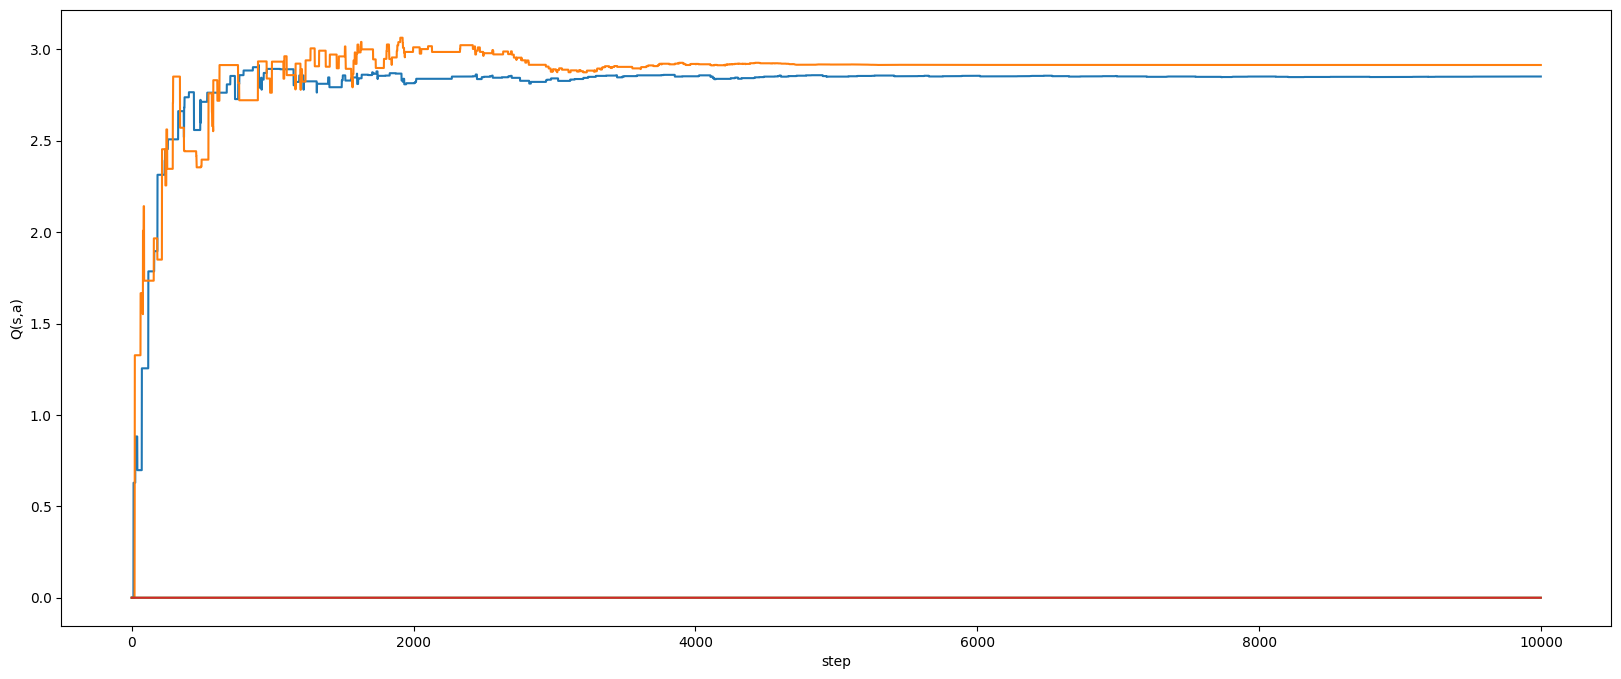

In [9]:
#Q_table_track = np.zeros( (dim_X, dim_Y, dim_action_a, dim_action_b, N_RL_iter) )

plt.figure(1, figsize=(20, 8))
M=N_RL_iter
plt.plot(Q_table_track[0,2,1,3,:M])
plt.plot(Q_table_track[0,2,2,3,:M])
plt.plot(Q_table_track[0,2,0,3,:M])
plt.plot(Q_table_track[0,2,3,3,:M])
plt.xlabel('step')
plt.ylabel('Q(s,a)')

# find the optimal policy using V_star

In [10]:
p_a_RL = np.zeros( (dim_X, dim_Y) )
p_b_RL = np.zeros( (dim_X, dim_Y) )
V_RL = np.zeros( (dim_X, dim_Y) )

In [11]:
for idx_x in range(dim_X):
  for idx_y in range(dim_Y):
    x = int(idx_x + 1)
    y = int(idx_y - N_Y)
    if y == -N_Y: # then sell order is not allowed
      action_a_list = [dim_action_a-1] # do nothing for ask order
      action_b_list = prices[prices<x/2] # the action is exactly equal to the index

      Q_values_xy = Q_table[idx_x, idx_y, :, :][np.ix_( action_a_list, action_b_list )]
      idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
      p_a = dim_action_a-1
      p_b = action_b_list[ idx_max_b[0] ]

    elif y == N_Y: # then buy order is not allowed
      action_a_list = prices[prices>x/2]
      action_b_list = [dim_action_b-1] # do nothing for buy order

      Q_values_xy = Q_table[idx_x, idx_y, :, :][np.ix_( action_a_list, action_b_list )]
      idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
      p_a = action_a_list[ idx_max_a[0] ]
      p_b = dim_action_b-1
      #print((x,y,p_a,p_b))
    else: # then both sell and buy orders are allowed
      action_a_list = prices[prices>x/2] # the action is exactly equal to the index
      action_b_list = prices[prices<x/2] # the action is exactly equal to the index

      Q_values_xy = Q_table[idx_x, idx_y, :, :][np.ix_( action_a_list, action_b_list )]
      idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
      p_a = action_a_list[ idx_max_a[0] ]
      p_b = action_b_list[ idx_max_b[0] ]
      #print((x,y,p_a,p_b))
    V_RL[idx_x, idx_y] = Q_values_xy.max()
    p_a_RL[idx_x, idx_y] = p_a
    p_b_RL[idx_x, idx_y] = p_b

the policy below is correct: column 0 is Y=0

In [12]:
p_a_RL

array([[3., 2., 2.],
       [3., 2., 2.],
       [3., 2., 2.]])

In [13]:
p_b_RL

array([[0., 0., 3.],
       [0., 0., 3.],
       [0., 0., 3.]])

In [14]:
V_RL

array([[2.85048112, 2.99008934, 2.91400965],
       [2.92566189, 3.04882356, 2.8912157 ],
       [2.94188193, 3.10096747, 2.88023351]])